In [6]:
from typing import ChainMap
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [7]:
'''
显示图片
输入：图片矩阵，画布大小：元组（宽，高）
'''
def showImg(img,figsize=(12,12),cmap = None):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img,cmap = cmap)
    plt.show()

In [8]:
# #消去干扰区域
# def get_clean(img):
#     contours,_=cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
#     retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)  #获取连通区域
# #     stats = sorted(stats,key=lambda x:(x[4]),reverse = True)
#     obj = np.argmax(stats[:,4][1:])+1
#     print(obj)
#     print(stats[4][1:])
#     print(stats[obj+1])
#     if(len(stats)>2):
#         for i in range(1,len(stats)):
#             if(i==obj):
#                 continue
#             stat = stats[i]
#             x,y,w,h = stat[0],stat[1],stat[2],stat[3]
#             label = labels[y:y+h,x:x+w]
#             lab = label.reshape(-1,)
#             lab = np.unique(lab)
#             lab = np.setdiff1d(lab,0)
#             for l in lab:
#                 seeds = np.argwhere(label==l) #获取下标
#                 if len(seeds)==stat[4]:
#                     row,col = seeds[:,0],seeds[:,1]
#                     img[y:y+h,x:x+w][row,col] = 0
#     return img

In [9]:
class RingFinder(object):
    bilateralFilter = dict(
        d=10,
        sigmaColor=10,
        sigmaSpace=30,
    )

    #消去干扰区域
    @staticmethod
    def get_clean(img):
        contours,_=cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)  #获取连通区域
#         stats = sorted(stats,key=lambda x:(x[4]),reverse = True)
        obj = np.argmax(stats[:,4][1:])+1
#         print(obg)
#         print(stats)
        if(len(stats)>2):
            for i in range(1,len(stats)):
                if(i==obj):
                    continue
                stat = stats[i]
                x,y,w,h = stat[0],stat[1],stat[2],stat[3]
                label = labels[y:y+h,x:x+w]
                lab = label.reshape(-1,)
                lab = np.unique(lab)
                lab = np.setdiff1d(lab,0)
                for l in lab:
                    seeds = np.argwhere(label==l) #获取下标
                    if len(seeds)==stat[4]:
                        row,col = seeds[:,0],seeds[:,1]
                        img[y:y+h,x:x+w][row,col] = 0
        return img
    @staticmethod
    def find_contour_outer_ellipse(image, threshold):
    # inner circle
        spot_mask = image >= threshold #保留大于阈值的部分
        spot_image = spot_mask.astype(np.uint8)
        #开闭运算 消除噪音 填补洞 预处理
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))         #定义矩形结构元素
        opened_img = cv2.morphologyEx(spot_image, cv2.MORPH_OPEN, kernel)
        closed_img = cv2.morphologyEx(opened_img, cv2.MORPH_CLOSE, kernel) 
        #得到最大的连通域
        img = RingFinder.get_clean(closed_img)
#         img = get_clean(closed_img)
        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  #轮廓检测 cv2.RETR_EXTERNAL  检测外轮廓 cv2.CHAIN_APPROX_SIMPLE 压缩元素
        assert len(contours) > 0
#         print(len(contours))
        if len(contours) == 1:
            ellipse = cv2.fitEllipse(contours[0])
        else:
            longest_contour_idx = np.argmax([len(x) for x in contours]) 
            ellipse = cv2.fitEllipse(contours[longest_contour_idx])
        return ellipse
    @staticmethod
    def find_contour_inner_ellipse(image, threshold):
        # inner circle
        spot_mask = image >= threshold #保留大于阈值的部分
        spot_image = spot_mask.astype(np.uint8)
        contours, _ = cv2.findContours(spot_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        assert len(contours) > 0
        longest_contour_idx = np.argmax([len(x) for x in contours])  #选取最大的轮廓拟合椭圆
        ellipse = cv2.fitEllipse(contours[longest_contour_idx])
        return ellipse

    @classmethod
    def find_ring(cls, image):
        if image.ndim == 2:
            img = image
        else:
            img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Blur
        img_blur = cv2.bilateralFilter(img, **cls.bilateralFilter) #双边滤波 保边去噪 高斯滤波会模糊边缘 双边滤波可以边缘保存

        # inner circle
        inner_ellipse = cls.find_contour_inner_ellipse(img_blur, threshold=250)
        outer_ellipse = cls.find_contour_outer_ellipse(img_blur, threshold=44)

        # # for debugging
        # image_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        # cv2.ellipse(image_color, inner_ellipse, color=[255, 0, 0], thickness=3)
        # cv2.ellipse(image_color, outer_ellipse, color=[255, 0, 0], thickness=3)
        # return image_color

        ring_dict = dict(
            inner_ellipse=inner_ellipse,
            outer_ellipse=outer_ellipse
        )
        return ring_dict

    @classmethod
    def crop_ring(cls, image, inner_ellipse, outer_ellipse):
        mask = np.zeros_like(image, dtype='uint8')
        if mask.ndim == 3:
            cv2.ellipse(mask, outer_ellipse, color=[1, 1, 1], thickness=-1) #白色填充大圆内部为1
            cv2.ellipse(mask, inner_ellipse, color=[0, 0, 0], thickness=-1) #黑色填充内部

        else:
            cv2.ellipse(mask, outer_ellipse, color=1, thickness=-1)
            cv2.ellipse(mask, inner_ellipse, color=0, thickness=-1)
        mask = np.float32(mask)
#         _, ax = plt.subplots(1,2)
#         ax[0].imshow(image,cmap = "gray")
#         ax[1].imshow(mask,cmap = "gray")
#         plt.show()
#         mask = np.int32(mask)
        return image * mask #获取环形


In [10]:
from common_lib import DataManager
from common_lib import AnnotationManager

In [11]:
image_root = "F:/mountMl_fan/bearing/"
data_json = DataManager.load("./jsons/pic5.json")

In [12]:
def contract(ellipseInfo,ring_dict,thresh):
    #innner_ellipse
    a = ellipseInfo["inner_ellipse"]
    b = ring_dict["inner_ellipse"]  
    inner_absDis = [a[0][0]-b[0][0],a[0][1]-b[0][1],a[1][0]-b[1][0],a[1][1]-b[1][1]]
    if(abs(a[2]-b[2])>90):
        inner_absDis.append(180-abs(a[2]-b[2]))
    else:
        inner_absDis.append(abs(a[2]-b[2]))
    #outer_ellipse
    a = ellipseInfo["outer_ellipse"]
    b = ring_dict["outer_ellipse"]  
    outer_absDis = [a[0][0]-b[0][0],a[0][1]-b[0][1],a[1][0]-b[1][0],a[1][1]-b[1][1]]
    absDis = inner_absDis+outer_absDis #分别表示内部椭圆的中心点 长短轴
    if(abs(a[2]-b[2])>90):
        outer_absDis.append(180-abs(a[2]-b[2]))
    else:
        outer_absDis.append(abs(a[2]-b[2]))    
    for item in absDis:
        if(abs(item)>thresh):
            print(absDis)
            return False
    return True

[0.0, 0.0, 0.0, 0.0, 0.0, 0.9371337890625, 10.3433837890625, 3.8367919921875, -32.9581298828125]


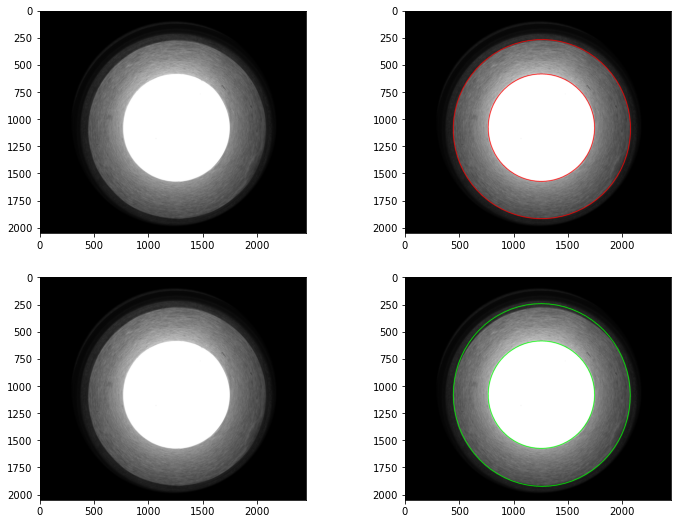

[0.0, 0.0, 0.0, 0.0, 0.0, 1.42724609375, 12.0611572265625, 7.656982421875, -38.728759765625]


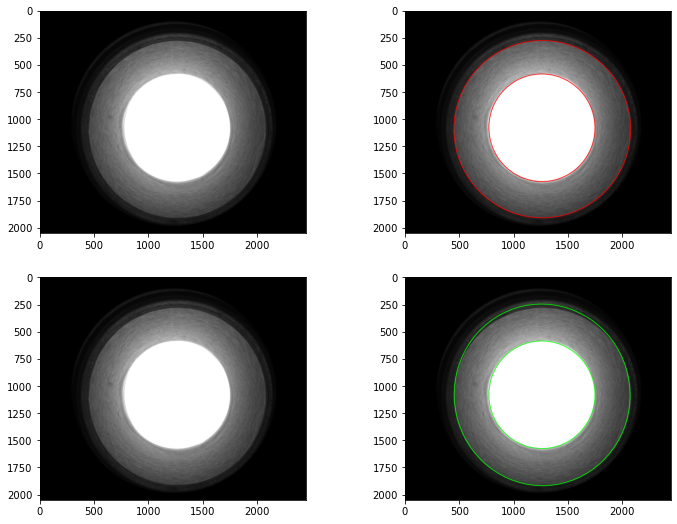

[0.0, 0.0, 0.0, 0.0, 0.0, 2.33056640625, 11.39306640625, 7.677001953125, -37.1278076171875]


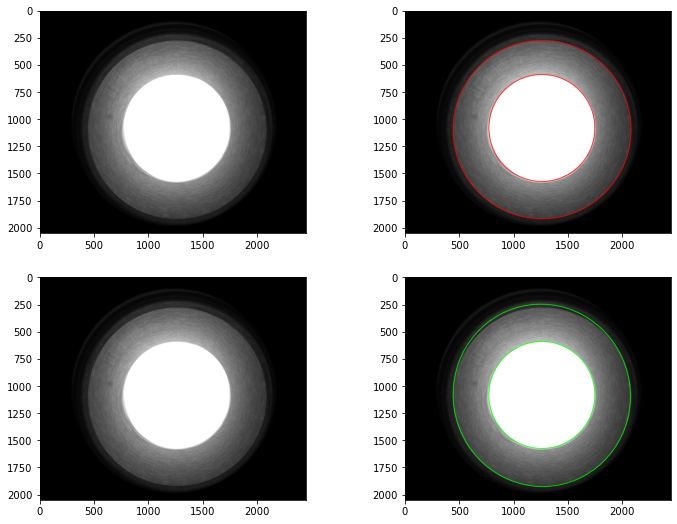

[0.0, 0.0, 0.0, 0.0, 0.0, 6.2823486328125, 13.2642822265625, -2.1328125, -37.0303955078125]


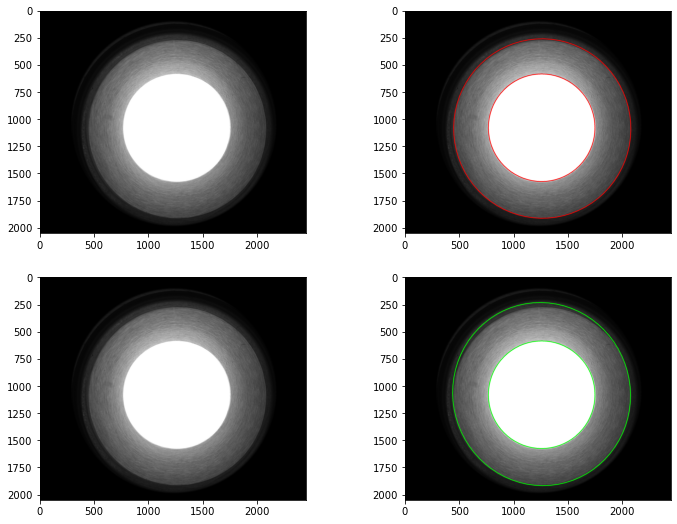

[0.0, 0.0, 0.0, 0.0, 0.0, -9.142578125, -5.699951171875, -34.9205322265625, -6.005859375]


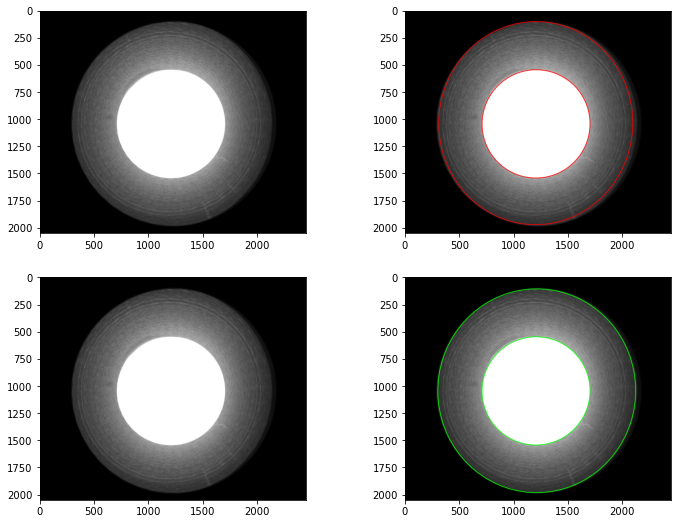

[0.0, 0.0, 0.0, 0.0, 0.0, -13.825439453125, -6.901123046875, -39.9759521484375, -6.088623046875]


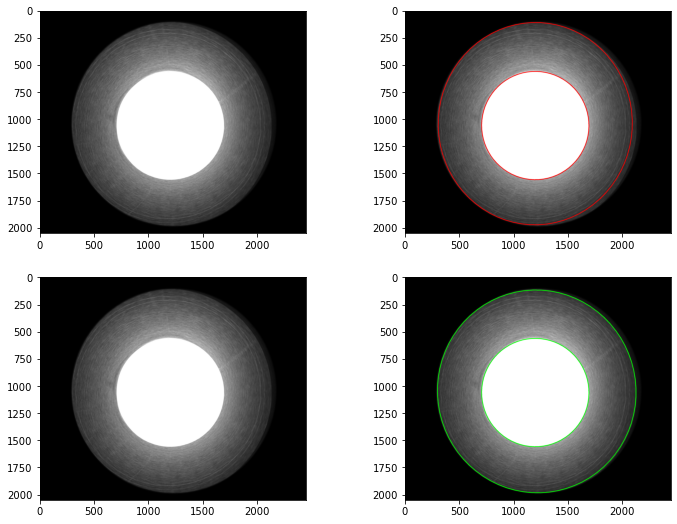

[0.0, 0.0, 0.0, 0.0, 0.0, -7.9569091796875, -5.3079833984375, -30.25537109375, -3.80224609375]


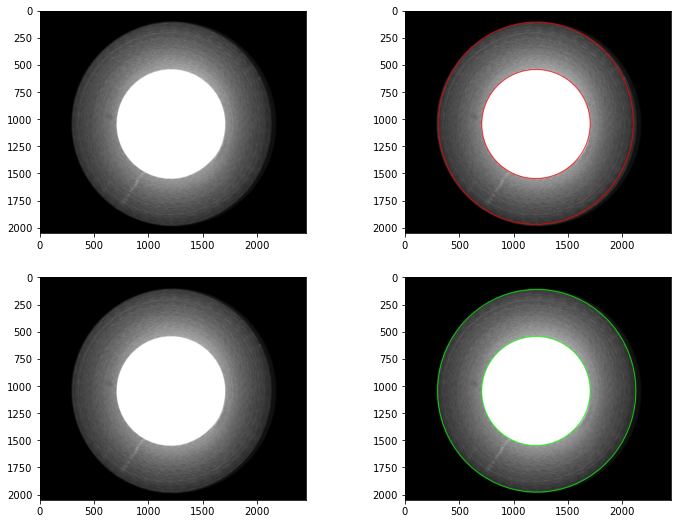

[0.0, 0.0, 0.0, 0.0, 0.0, -11.137451171875, -8.806884765625, -48.3551025390625, -7.86962890625]


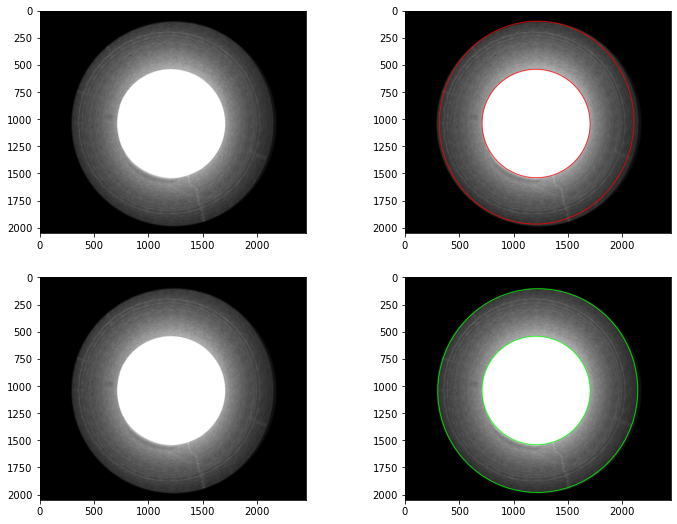

[0.0, 0.0, 0.0, 0.0, 0.0, -9.649658203125, -4.81201171875, -31.0521240234375, 0.3770751953125]


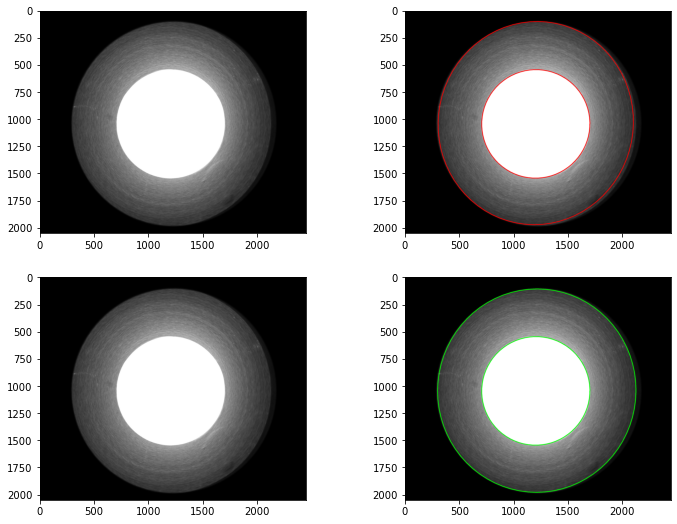

[0.0, 0.0, 0.0, 0.0, 0.0, -8.43017578125, -5.6561279296875, -43.0081787109375, -5.962646484375]


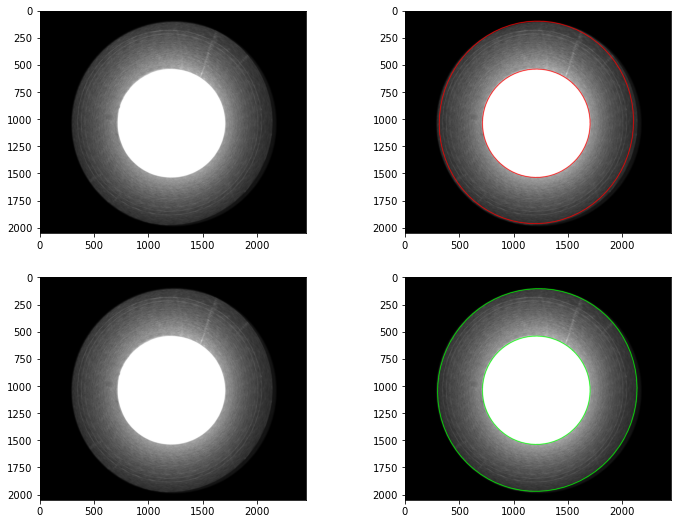

[0.0, 0.0, 0.0, 0.0, 0.0, -8.065185546875, -5.1285400390625, -30.091552734375, -6.2811279296875]


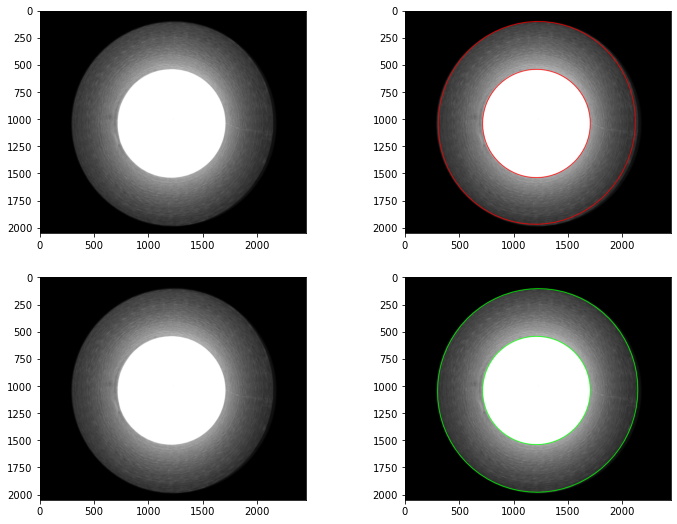

[0.0, 0.0, 0.0, 0.0, 0.0, -6.166259765625, -3.9117431640625, -31.8328857421875, 0.4139404296875]


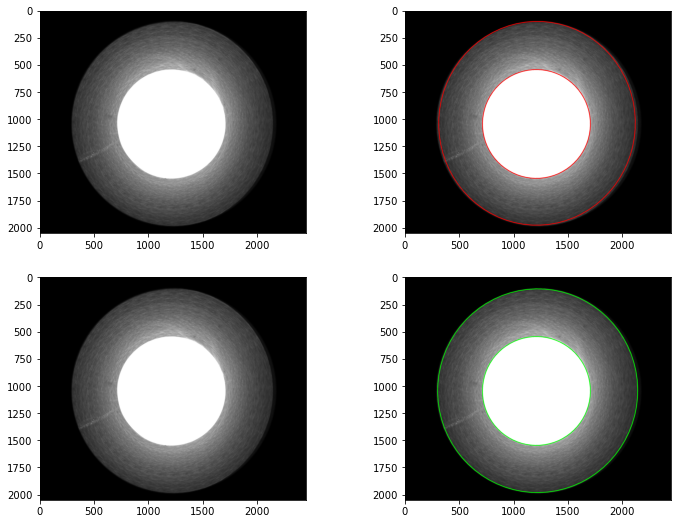

[0.0, 0.0, 0.0, 0.0, 0.0, -9.591064453125, -9.247802734375, -43.7884521484375, -8.4130859375]


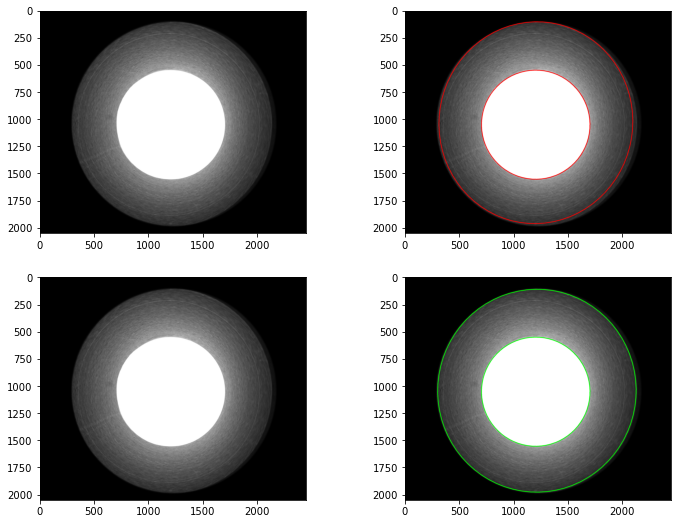

[0.0, 0.0, 0.0, 0.0, 0.0, -14.1727294921875, -6.7491455078125, -35.8472900390625, -11.9483642578125]


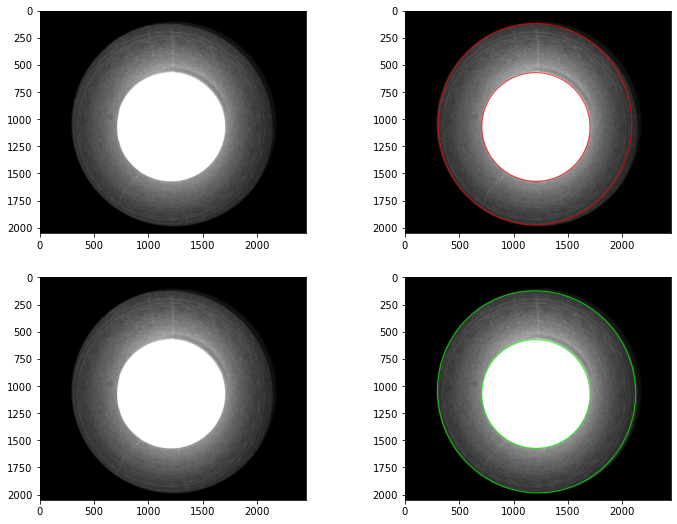

In [13]:
img_list = []
ellipseInfo_list = []
error_list = []
for rec in data_json:
#     print(rec)
#     break
    img = cv2.imread(image_root+rec["info"]["image_path"])
    
    assert len(img)!=0
    img_list.append(img)
    ellipseInfo = rec["info"]["ellipses"]
    ring_dict = RingFinder.find_ring(img)
    if not(contract(ellipseInfo,ring_dict,30)):
        error_list.append({"image_path":rec["info"]["image_path"],"ellipse_rec":ellipseInfo,"new_ellipses":ring_dict})
        img_rec = img.copy()
        img_new = img.copy()
        cv2.ellipse(img_rec, ellipseInfo["inner_ellipse"], color=[255, 0, 0], thickness=6)
        cv2.ellipse(img_rec, ellipseInfo["outer_ellipse"], color=[255, 0, 0], thickness=6)
        cv2.ellipse(img_new, ring_dict["inner_ellipse"], color=[0, 255, 0], thickness=6)
        cv2.ellipse(img_new, ring_dict["outer_ellipse"], color=[0, 255, 0], thickness=6)
#         image_cropped_rec = RingFinder.crop_ring(img, **ellipseInfo) # crop image with the found ellipses
#         image_cropped_new = RingFinder.crop_ring(img, **ring_dict) # crop image with the found ellipses
        _, ax = plt.subplots(2,2,figsize=(12, 9))
#         img = img / 255.
        ax[0][0].imshow(img)
        ax[0][1].imshow(img_rec)
        ax[1][0].imshow(img)
        ax[1][1].imshow(img_new)
        plt.show()

In [14]:
len(error_list)  #threash30 outer:45 error 9; threash30 outer:38 error 49; threash30 outer:43 error 36

14

1


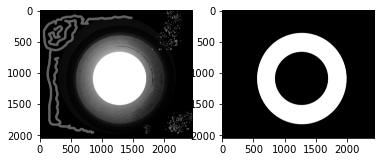

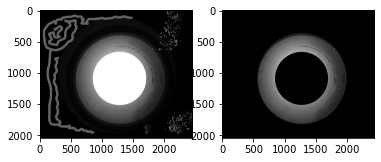

In [5]:
# this could be rgb or gray image
image = cv2.imread('./imgs/examples/6.png')
ring_dict = RingFinder.find_ring(image)  # find ellipses
image_cropped = RingFinder.crop_ring(image, **ring_dict) # crop image with the found ellipses
#Python中，（*）会把接收到的参数形成一个元组，而（**）则会把接收到的参数存入一个字典
# plot results
_, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(image_cropped)
plt.show()

In [9]:
ring_dict["inner_ellipse"]  

((1255.0172119140625, 1084.1624755859375),
 (982.1290283203125, 984.8865966796875),
 176.07012939453125)

In [10]:
ellipseInfo

{'inner_ellipse': [[1255.0172119140625, 1084.1624755859375],
  [982.1290283203125, 984.8865966796875],
  176.07012939453125],
 'outer_ellipse': [[1253.3505859375, 1098.245849609375],
  [1635.4244384765625, 1637.8980712890625],
  84.0263900756836]}

In [149]:
#消去干扰区域
def get_clean(img):
    contours,_=cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)  #获取连通区域
    stats = sorted(stats,key=lambda x:(x[4]),reverse = True)
#     print(stats)
    if(len(stats)>2):
        for i in range(2,len(stats)):
            stat = stats[i]
            x,y,w,h = stat[0],stat[1],stat[2],stat[3]
            label = labels[y:y+h,x:x+w]
            lab = label.reshape(-1,)
            lab = np.unique(lab)
            lab = np.setdiff1d(lab,0)
            for l in lab:
                seeds = np.argwhere(label==l) #获取下标
                if len(seeds)==stat[4]:
                    row,col = seeds[:,0],seeds[:,1]
                    img[y:y+h,x:x+w][row,col] = 0
    return img

In [150]:
def find_contour_outer_ellipse(image, threshold):
    # inner circle
    spot_mask = image >= threshold #保留大于阈值的部分
    spot_image = spot_mask.astype(np.uint8)
    #开闭运算 消除噪音 填补洞 预处理
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))         #定义矩形结构元素
    opened_img = cv2.morphologyEx(spot_image, cv2.MORPH_OPEN, kernel)
    closed_img = cv2.morphologyEx(opened_img, cv2.MORPH_CLOSE, kernel) 
    #得到最大的连通域
    img = get_clean(closed_img) 
    _, ax = plt.subplots(1,2)
    ax[0].imshow(image,cmap = "gray")
    ax[1].imshow(img,cmap = "gray")
    plt.show()
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  #轮廓检测 cv2.RETR_EXTERNAL  检测外轮廓 cv2.CHAIN_APPROX_SIMPLE 压缩元素
    assert len(contours) > 0
    print(contours)
    if len(contours) == 1:
        ellipse = cv2.fitEllipse(contours[0])
    else:
        longest_contour_idx = np.argmax([len(x) for x in contours]) 
        ellipse = cv2.fitEllipse(contours[longest_contour_idx])
    return ellipse

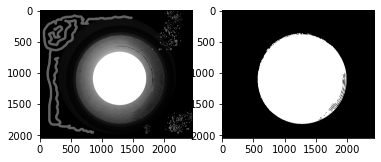

[array([[[1240,  370]],

       [[1238,  372]],

       [[1237,  372]],

       ...,

       [[1249,  371]],

       [[1247,  371]],

       [[1246,  370]]], dtype=int32)]
((1279.1474609375, 1102.6148681640625), (1421.7454833984375, 1444.9703369140625), 166.11158752441406)


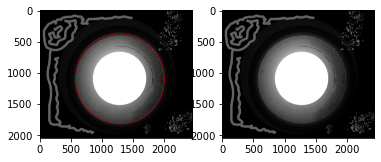

In [151]:
# this could be rgb or gray image
image = cv2.imread('./imgs/examples/6.png')
if image.ndim == 2:
    img = image
else:
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Blur
img_blur = cv2.bilateralFilter(img, d=10,sigmaColor=10,sigmaSpace=30)
ellipse = find_contour_outer_ellipse(img_blur,30)  # find ellipses
print(ellipse)
cv2.ellipse(image, ellipse, color=[255, 0, 0], thickness=5)
_, ax = plt.subplots(1,2)
ax[0].imshow(image,cmap = "gray")
ax[1].imshow(img,cmap = "gray")
plt.show()
# showImg(image)

In [152]:
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)  #获取连通区域
stats

array([[      0,       0,    2448,    2048, 1856231],
       [   2131,       0,       8,       5,      29],
       [   2148,       0,       8,       8,      49],
       ...,
       [   1437,    2027,       1,       1,       1],
       [    409,    2032,       1,       1,       1],
       [   1082,    2035,       1,       1,       1]], dtype=int32)

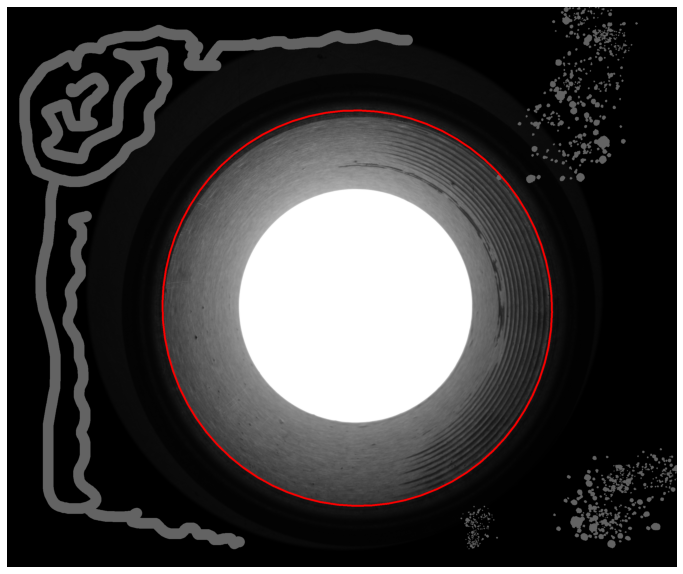

In [139]:
showImg(image)

In [ ]:
       # if(len(stats)>2):
        #     for i in range(1,len(stats)):
        #         if(i==obj):
        #             continue
        #         stat = stats[i]
        #         x,y,w,h = stat[0],stat[1],stat[2],stat[3]
        #         label = labels[y:y+h,x:x+w]
        #         lab = label.reshape(-1,)
        #         lab = np.unique(lab)
        #         lab = np.setdiff1d(lab,0)
        #         for l in lab:
        #             seeds = np.argwhere(label==l) #获取下标
        #             if len(seeds)==stat[4]:
        #                 row,col = seeds[:,0],seeds[:,1]
        #                 img[y:y+h,x:x+w][row,col] = 0